100%|██████████| 949/949 [00:24<00:00, 38.52it/s]


upshadow_ic: -0.006


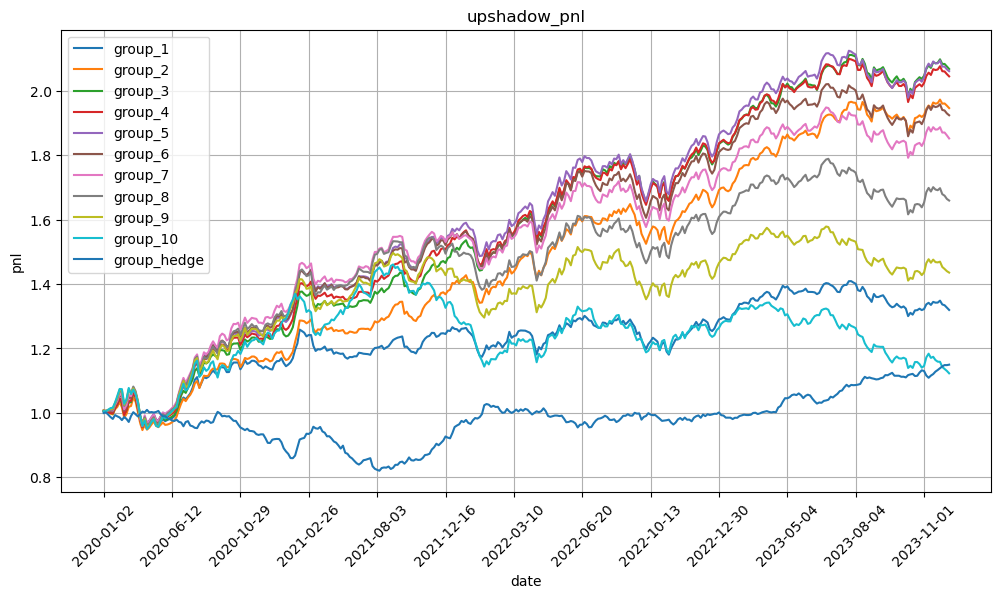

In [3]:
# Copyright © [2023] [Bob]
# All rights reserved. This work is protected under copyright laws and international treaties. 
# Unauthorized reproduction, distribution, or modification of this work in any form or by any means, 
# without the prior written permission of the copyright holder, is strictly prohibited. 
# Violators will be prosecuted to the fullest extent of the law.


import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import os
import warnings
warnings.filterwarnings('ignore')


# Configuration
start_date = '2020-01-01'
end_date = '2023-11-25'
trade_date_path = './data/date.pkl'    #
factor_path = './newclass_feature/upshadow'  #factor
ret_path = './data/data_ret'     #ret
ud_path = './data/data_ud_new'      
group = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]     

# Load trade date data
trade_date = pickle.load(open(trade_date_path, 'rb'))
factor_files = sorted(os.listdir(factor_path))
ret_files = sorted(os.listdir(ret_path))
pnl = {}
ic = {}
result = pd.DataFrame()

# Process data
for file in tqdm(factor_files):
    date_tmp = file[:-4]
    next_date = trade_date[trade_date.index(date_tmp) + 1]

    if file in ret_files and date_tmp >= start_date and date_tmp <= end_date:
        
        factor_tmp = pd.read_csv(f'{factor_path}/{file}', index_col=0, header=0)
        ret_tmp = pd.read_csv(f'{ret_path}/{next_date}.csv', index_col=0, header=0)
        ud_tmp = pd.read_csv(f'{ud_path}/{next_date}.csv', index_col=0, header=0)   #tag
        ud_tmp.set_index('code', inplace=True)
        
        merged = pd.concat([ret_tmp, ud_tmp[['zt', 'dt', 'paused']]], axis=1)
        
        index_tmp = factor_tmp.index.intersection(ret_tmp.index)
        
        res_fr = pd.concat([factor_tmp.loc[index_tmp, :], merged.loc[index_tmp, :]], axis=1)
        
        final = res_fr.loc[(res_fr['zt'] == 0) & (res_fr['dt'] == 0) & 
                           (res_fr['paused'] == 0), :].replace([np.inf, -np.inf], 0)

        for col in factor_tmp.columns.to_list():
            if col not in pnl:     #第一天
                pnl[col] = pd.DataFrame()
                ic[col] = []
                
                
            if len(final[col].dropna().quantile(group).unique()) < 11:
                continue

            final[col + '_group'] = pd.qcut(final[col], 10, labels=False, duplicates='drop') + 1

            final['ret_1_pnl'] = final['1vwap_pct']

            result_agg = final.pivot_table(index=col + '_group', values=['ret_1_pnl'], aggfunc=np.mean)

            pnl_tmp = result_agg.T
            pnl_tmp = pnl_tmp.loc[pnl_tmp.index == 'ret_1_pnl']
            pnl_tmp['date'] = date_tmp
            pnl_tmp.set_index('date', inplace=True)
            pnl_tmp.columns.name = None
            pnl_tmp.index.name = None
            pnl[col] = pd.concat([pnl[col], pnl_tmp], axis=0)

            ic_tmp = final[col].corr(final['1vwap_pct'])
            ic[col].append(ic_tmp)

# Calculate effectiveness
for factor in ic:
    pnl[factor]['hedge'] = pnl[factor][1] - pnl[factor][10]   #1-10
    df = pnl[factor]
    cumulative_returns = (1 + df).cumprod()
    dates = df.index
    plt.figure(figsize=(12, 6))
    for group in cumulative_returns.columns:
        plt.plot(dates, cumulative_returns[group], label=f'group_{group}')
    plt.title(factor + '_pnl')
    plt.xlabel('date')
    plt.ylabel('pnl')
    plt.legend()
    plt.grid(True)
    x_ticks_interval = 30
    plt.xticks(dates[::x_ticks_interval], rotation=45)

    ic_tmp = np.mean(ic[factor]).round(3)
    print(factor + '_ic:', ic_tmp)


In [9]:
factor_tmp.columns.to_list()

['upshadow']

In [15]:
ic['upshadow']

[-0.03065158832652045,
 -0.0032833026633155155,
 0.007345805255865852,
 0.03676585105546323,
 -0.045385306973710925,
 -0.028785225917871027,
 -0.002359861718138921,
 0.03407085820528757,
 0.018698972031662375,
 0.0008369988899311637,
 -0.0051229783792496155,
 -0.004922168011731199,
 -0.02901944471164585,
 -0.043005154928126045,
 0.003405696883361789,
 0.004299311360195386,
 0.01962232361214586,
 -0.07414677843722567,
 -0.0028622882623484613,
 -0.022422140173844318,
 0.005981374654321594,
 0.015085057596929751,
 0.03017616255065034,
 -0.006681678049659943,
 -0.008041810459911335,
 -0.0069389564610604325,
 0.012264172005860514,
 0.011971550024257777,
 0.03731116475278252,
 0.01498383613260468,
 -0.013357954106277506,
 -0.010493406145390278,
 -0.020501603569607212,
 0.023957468088722192,
 -0.008707410329337759,
 0.055537613805557474,
 -0.024086962636161256,
 -0.03270532601275589,
 0.06702530486086732,
 0.022421181163904253,
 0.027129051220745094,
 0.020971686063977583,
 -0.056381493606368

In [ ]:
1 2 3 4 5 6 7 8 9 11 11    10% 

In [2]:
final

,upshadow,date,1vwap_pct,5vwap_pct,10vwap_pct,15vwap_pct,zt,dt,paused
code,,,,,,,,,
000001.XSHE,2.54,2023-11-27,-0.002345,NaN,NaN,NaN,0,0,0.0
000002.XSHE,18.57,2023-11-27,-0.005439,NaN,NaN,NaN,0,0,0.0
000004.XSHE,2.61,2023-11-27,-0.014998,NaN,NaN,NaN,0,0,0.0
000005.XSHE,0.11,2023-11-27,-0.000663,NaN,NaN,NaN,0,0,0.0
000006.XSHE,4.65,2023-11-27,-0.005046,NaN,NaN,NaN,0,0,0.0
...,...,...,...,...,...,...,...,...,...
688799.XSHG,0.38,2023-11-27,0.001270,NaN,NaN,NaN,0,0,0.0
688800.XSHG,0.08,2023-11-27,0.010775,NaN,NaN,NaN,0,0,0.0
688819.XSHG,0.00,2023-11-27,0.004344,NaN,NaN,NaN,0,0,0.0


In [14]:
ic['vwap']

[-0.03702971359327845,
 -0.06242235031738786,
 -0.0235759789571964,
 0.016177190691760154,
 -0.011029704572643463,
 0.014489829841993008,
 -0.04461049450794186,
 0.034790425261328715,
 -0.010127698702037986,
 0.00866291497375902,
 0.02267451344578403,
 -0.04376582490829974,
 0.06580746503856298,
 -0.0033095833879419933,
 0.051838217645728844,
 -0.003013310799235337,
 -0.10195646311784978,
 -0.043048596022758366,
 -0.06616699300835722,
 -0.060642784431785265,
 0.04536090983948781,
 -0.001995034103343527,
 0.004155817529498307,
 0.02749606757664467,
 -0.06341956144861949,
 -0.11586406891552574,
 -0.04614210694732159,
 0.033266808301445565,
 -0.009213580700696401,
 -0.05793172377738446,
 0.0002696887419969989,
 -0.01763115889760622,
 0.06604794016782488,
 0.08204165873147981,
 0.013519968715932053,
 -0.056090105064451716,
 -0.017308451191477222,
 -0.023508992116461375,
 -0.04497193916315144,
 -0.06642352290829855,
 0.06808769610807722,
 -0.11543687267100414,
 0.018786242273075546,
 0.0127

In [12]:
pnl['vwap']

,1,2,3,4,5,6,7,8,9,10,hedge
2020-01-02,0.008978,0.007283,0.005785,0.006066,0.007447,0.006731,0.004683,0.006461,0.004320,0.004171,0.004807
2020-01-03,0.012920,0.011754,0.011040,0.011266,0.011191,0.009044,0.012427,0.010883,0.010286,0.005056,0.007864
2020-01-06,0.000341,-0.003379,-0.001141,0.000838,0.000565,-0.001047,0.000165,-0.003722,-0.002068,-0.004905,0.005247
2020-01-07,0.005084,0.005034,0.006122,0.005861,0.005023,0.003536,0.004809,0.004183,0.004873,0.005777,-0.000693
2020-01-08,0.002210,0.002150,0.000066,0.001097,0.000673,-0.000079,0.000726,0.001752,0.000723,0.001502,0.000708
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-20,-0.009861,-0.009860,-0.010582,-0.009416,-0.009563,-0.010022,-0.008708,-0.007467,-0.006873,-0.010016,0.000155
2023-11-21,-0.001735,-0.002887,-0.000222,-0.000855,-0.001956,0.000148,-0.002417,-0.000515,-0.002007,-0.002038,0.000303
2023-11-22,-0.006409,-0.006314,-0.006228,-0.005709,-0.005583,-0.006429,-0.005193,-0.003141,-0.000550,-0.000809,-0.005600
2023-11-23,-0.001748,-0.002167,-0.003994,-0.002584,-0.004456,-0.004869,-0.002524,-0.004131,-0.006852,-0.007275,0.005527


In [3]:
pnl['vwap']

,1,2,3,4,5,6,7,8,9,10,hedge
2020-01-02,0.008978,0.007283,0.005785,0.006066,0.007447,0.006731,0.004683,0.006461,0.004320,0.004171,0.004807
2020-01-03,0.012920,0.011754,0.011040,0.011266,0.011191,0.009044,0.012427,0.010883,0.010286,0.005056,0.007864
2020-01-06,0.000341,-0.003379,-0.001141,0.000838,0.000565,-0.001047,0.000165,-0.003722,-0.002068,-0.004905,0.005247
2020-01-07,0.005084,0.005034,0.006122,0.005861,0.005023,0.003536,0.004809,0.004183,0.004873,0.005777,-0.000693
2020-01-08,0.002210,0.002150,0.000066,0.001097,0.000673,-0.000079,0.000726,0.001752,0.000723,0.001502,0.000708
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-20,-0.009861,-0.009860,-0.010582,-0.009416,-0.009563,-0.010022,-0.008708,-0.007467,-0.006873,-0.010016,0.000155
2023-11-21,-0.001735,-0.002887,-0.000222,-0.000855,-0.001956,0.000148,-0.002417,-0.000515,-0.002007,-0.002038,0.000303
2023-11-22,-0.006409,-0.006314,-0.006228,-0.005709,-0.005583,-0.006429,-0.005193,-0.003141,-0.000550,-0.000809,-0.005600
2023-11-23,-0.001748,-0.002167,-0.003994,-0.002584,-0.004456,-0.004869,-0.002524,-0.004131,-0.006852,-0.007275,0.005527
